___
<h1 align="center"><strong>Projet télédétection avancée</strong></h1>

<p align="center"><strong>Jeu de données :</strong> Pyrénées 2024-2025</p>
<p align="center"><strong>Auteur :</strong> Lisa Ventura</p>


---

## **1. Configuration de l’environnement et des données**

### Objectif

Ce bloc a pour objectif d’initialiser l’environnement de travail et de définir l’ensemble des données nécessaires au traitement des images Sentinel-2 dans le cadre du projet.

### Contenu du bloc

Il comprend :
- l’importation des **bibliothèques standards** de calcul scientifique et de gestion de fichiers,
- le chargement des **modules géospatiaux** et des **fonctions personnalisées** dédiées au projet,
- la mise en place de **l’arborescence de travail**,
- la définition des chemins vers :
  - les données raster (bandes spectrales Sentinel-2),
  - les données vecteur de référence terrain (shapefile des strates),
  - le raster de sortie pour l’indice ARI.

### Préparation de l’analyse

Enfin, ce bloc construit dynamiquement :
- la liste des bandes spectrales utilisées pour l’analyse multi-bandes,
- les dates d’acquisition associées,

constituant ainsi la base des traitements de classification et d’analyse temporelle ultérieurs.

---


In [1]:
import sys, os, numpy as np, pandas as pd
sys.path.append('..')
from osgeo import gdal
gdal.UseExceptions()
import my_function as my
from libsigma import classification as cl
my.creation_dossier()
data_dir = '../data/projet_eval'
shp_path = os.path.join(data_dir, 'PI_strates_pyrenees_32630.shp')
b03_path = os.path.join(data_dir, 'pyrenees_24-25_B03.tif')
b05_path = os.path.join(data_dir, 'pyrenees_24-25_B05.tif')
b04_path = os.path.join(data_dir, 'pyrenees_24-25_B04.tif')
b02_path = os.path.join(data_dir, 'pyrenees_24-25_B02.tif')
ari_path = '../results/ARI_serie_temp.tif'

liste_fichiers_bandes = [f"{data_dir}/pyrenees_24-25_B{b}.tif" for b in ["02","03","04","05","06","07",
"08","8A","11","12"]]
dates = ["11/10/24", "21/10/24", "28/11/24", "05/12/24", "14/01/25", "23/02/25", "29/05/25", "18/06/25",
 "16/07/25", "24/08/25"]

Dossier vérifié/créé : /home/onyxia/work/results
Dossier vérifié/créé : /home/onyxia/work/results/figure


---

## **2. Rasterisation des données vecteur et analyse des données d’entrée**

### Objectif

Cette étape vise à transformer les données vecteur issues du terrain (shapefile des strates) en rasters alignés sur les images Sentinel-2, afin de les rendre exploitables pour les traitements raster et les phases de classification supervisée.

### Contenu du bloc

Les opérations réalisées sont les suivantes :

- **Rasterisation des strates**  
  Le shapefile est converti en raster selon le champ `strate`, produisant une carte raster des classes de référence terrain, parfaitement alignée sur la géométrie de la bande B03 Sentinel-2.

- **Rasterisation des identifiants de polygones**  
  Une seconde rasterisation est effectuée à partir du champ `id`, permettant d’attribuer un identifiant unique à chaque polygone dans le raster. Cette couche est utile pour le suivi spatial des entités, le contrôle qualité et certaines stratégies d’échantillonnage. Il sera utile pour définir les groupes si une stratégie Kfold stratified est utilisée par exemple.

- **Analyse des données d’entrée**  
  Une fonction d’analyse est ensuite appliquée afin de comptabiliser et afficher le nombre de polygones et de pixels attribués à chaque strates dans les **données échantillons**.

### Rôle dans la chaîne de traitement

Cette étape constitue un **prétraitement fondamental** permettant :
- d’assurer la compatibilité entre données terrain et images satellites,
- de faire une première visualisation de ce que comprend notre jeu de données.


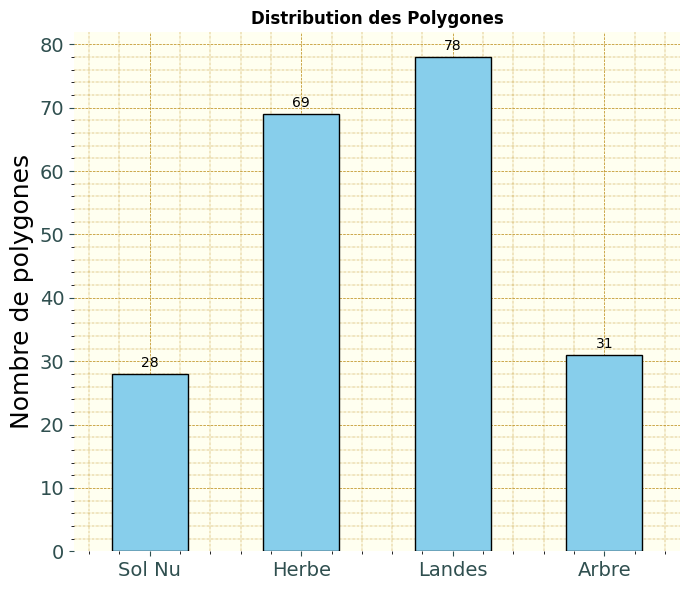

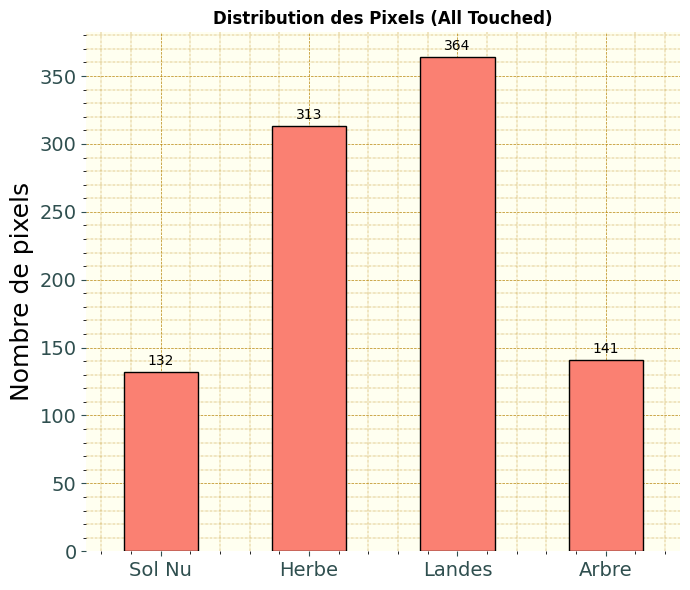

In [2]:
my.rasterize_shapefile(shp_path, b03_path, '../results/strate_raster.tif', field="strate")
my.rasterize_shapefile(shp_path, b03_path, '../results/poly_id_raster.tif', field="id")

import matplotlib.pyplot as plt

import logging
import warnings

# On coupe les alertes spécifiques aux polices de matplotlib
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", message=".*font family.*not found.*")

# Maintenant vous pouvez appeler votre fonction sans les messages rouges
my.analyser_donnees_entree(shp_path, '../results/strate_raster.tif')

**Avant de commenter ces deux graphiques, il est essentiel de comprendre la méthode de comptabilisation des pixels par strate.**

La rasterisation a été réalisée selon le principe de la sélection par intersection (**All Touched**). Contrairement à une sélection restrictive basée uniquement sur le centre du pixel, cette option attribue un pixel de 10 m × 10 m à une strate dès qu’une partie, même minimale, de sa surface **intersecte** un polygone d’entraînement.

Cette approche permet d’**augmenter significativement** le nombre de pixels associés à chaque strate, garantissant ainsi que l’ensemble des éléments paysagers observés sur le terrain soit pris en compte lors de l’apprentissage du modèle. Elle est particulièrement pertinente pour capturer les zones de transition, les petits objets paysagers ou les éléments linéaires, qui auraient pu être ignorés avec une sélection par centre.

L’analyse de la représentativité de l’échantillonnage met en évidence plusieurs points clés :

-> **Ratio pixels/polygone** : il est en moyenne de 4.6, ce qui traduit la petite taille des polygones d’échantillonnage devant la résolution spatiale des rasters.

-> **Stratégie de validation** : le déséquilibre numérique entre les classes justifie l’utilisation du StratifiedGroupKFold. Cette méthode garantit que chaque classe, y compris les classes minoritaires, est représentée de manière équitable lors de la validation croisée, assurant ainsi la robustesse et la fiabilité des scores de précision finaux.



---

## **3. Calcul de l’indice ARI (Anthocyanin Reflectance Index)**

### Objectif

Ce bloc a pour objectif de **calculer l’indice ARI** à partir des bandes Sentinel-2 B03 (vert) et B05 (red-edge), puis de sauvegarder le résultat sous forme de raster multi-bandes. L’ARI est un indice spectral utilisé pour détecter la présence d’anthocyanes dans la végétation, et constitue une variable supplémentaire utile pour la classification supervisée.

In [3]:
# --- 3. CALCUL ARI ---
ds_b03, ds_b05 = gdal.Open(b03_path), gdal.Open(b05_path)
ari_stack = my.calcul_ari_serie(ds_b03, ds_b05)
# Sauvegarde rapide de l'ARI (nécessaire pour cl.get_samples_from_roi)
driver = gdal.GetDriverByName('GTiff')
out_ds = driver.Create(ari_path, ds_b03.RasterXSize, ds_b03.RasterYSize, ds_b03.RasterCount, gdal.GDT_Float32)
out_ds.SetGeoTransform(ds_b03.GetGeoTransform())
out_ds.SetProjection(ds_b03.GetProjection())
for i in range(ds_b03.RasterCount):
    out_ds.GetRasterBand(i+1).WriteArray(ari_stack[:,:,i])
out_ds = None

---

## **4. Préparation des données et suivi phénologique**

### Objectif

Ce bloc a pour objectif de **préparer les données d’entrée pour la classification** et d’analyser la **phénologie à partir de l’indice ARI**.  
Il combine l’extraction des pixels par strate, le filtrage des valeurs valides, et la visualisation de l’évolution temporelle des strates à l’aide de l’ARI.

### Contenu du bloc

Les opérations réalisées sont les suivantes :

**Extraction multidimensionnelle** (X, Y, Groups) : Le script parcourt l'ensemble de la pile temporelle (bandes Sentinel-2 et indice ARI) pour extraire les valeurs des pixels situés sur les zones d'entraînement. Il génère simultanément le vecteur des classes cibles (Y) et les identifiants de groupes (Groups) nécessaires à la validation croisée.

**Nettoyage et structuration de la matrice** : Un masque est appliqué pour éliminer les pixels hors zone d'étude ou sans étiquette. Les données sont ensuite nettoyées des valeurs manquantes (NaN) et empilées pour former une matrice de valeurs prête à être soumise à l'algorithme d'apprentissage.

**Suivi de la phénologie** (Indice ARI) : Une visualisation graphique est générée pour tracer les courbes d'évolution de l'indice ARI (Anthocyanin Reflectance Index) sur 10 dates, de octobre 2024 à août 2025. Cela permet d'observer un cycle saisonnier de chaque strate végétale.


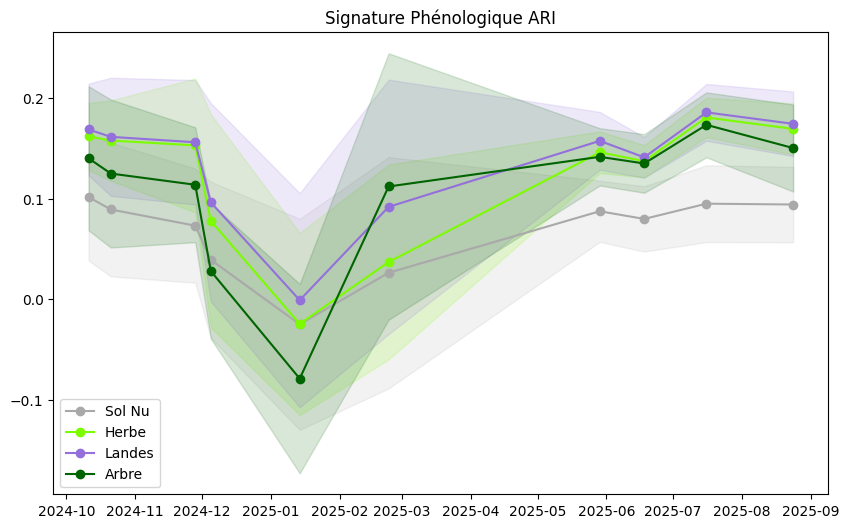

In [4]:
X_list = [cl.get_samples_from_roi(c, '../results/strate_raster.tif')[0] for c in liste_fichiers_bandes + [ari_path]]
Y = cl.get_samples_from_roi(liste_fichiers_bandes[0], '../results/strate_raster.tif')[1].ravel()
groups = cl.get_samples_from_roi('../results/poly_id_raster.tif', '../results/strate_raster.tif')[0].ravel()

mask = (Y > 0)
X_c, Y_c, G_c = np.nan_to_num(np.hstack(X_list)[mask]), Y[mask], groups[mask]

dates_completes = ["2024-10-11", "2024-10-21", "2024-11-28", "2024-12-05", 
"2025-01-14", "2025-02-23", "2025-05-29", "2025-06-18", "2025-07-16", "2025-08-24"]
my.tracer_phenologie_ari(X_list[-1][mask], Y_c, dates_completes)



### **Comportement de l'ARI des différentes strates dans le temps**

L'analyse des **signatures phénologiques** issues de l'indice ARI (Anthocyanin Reflectance Index) permet de distinguer les quatre strates de végétation, chacune présentant une réponse pigmentaire unique aux variations saisonnières des Pyrénées.

**La strate « Sol Nu »** : 
La strate « sol nu » présente les valeurs d'ARI les plus faibles et les plus stables de toute la série chronologique. Contrairement aux strates biologiques, le minéral ne possède pas de pigments actifs, ce qui traduit des variations saisonnières plus faibles. L’écart avec les autres strates atteint son maximum durant la période estivale.

Comportement global des **strates végétalisées**
Les strates « landes », « herbes » et « arbres » partagent un cycle saisonnier plus complexe, marqué par un minimum thermique en janvier. Ce creux s'explique par le stress physiologique intense subi par les plantes (températures négatives) ou par la présence d'un manteau neigeux masquant la signature pigmentaire. À l'**automne**, une hiérarchie s'installe : les landes dominent, suivies par l'herbe, puis les arbres, illustrant des **rythmes de sénescence** (vieillissement des feuilles) différenciés.

**La strate « Landes » : Dominance pigmentaire**
La strate « landes » (arbrisseaux bas) affiche globalement l'ARI le plus élevé de l'année. Sa reprise après le minimum de janvier est progressive : elle entame une phase de croissance longue pour atteindre son plateau de maturité pigmentaire en mai. 

**La strate « Herbe » : Une dynamique parallèle**
La signature de l'herbe suit une trajectoire parallèle à celle des landes, mais avec une intensité systématiquement inférieure. Un point de bascule majeur est observé fin février : l'herbe se distingue alors radicalement de la strate arborée avec un ARI proche de 0,25, contre seulement 0,125 pour les arbres. Cette divergence précoce suggère un redémarrage de l'activité métabolique des pelouses alpines dès les premiers redoux, bien avant celui des ligneux hauts.

**La strate « Arbres » : Une réactivité hivernale brutale**
La strate arborée se distingue par une instabilité hivernale marquée. On observe un pic bas fin et brutal durant l'hiver. La chute est rapide, mais la remontée l'est tout autant : l'indice passe de -0,05 le 14/01/2025 à 0,125 le 23/02/2025. Cette forte amplitude témoigne d'une sensibilité accrue des strates hautes aux variations climatiques de début d'année, marquant une rupture nette avec la relative inertie des strates basses (landes et herbes) durant cette même période.

<hr style="border-top: 1px dotted #999;">


<h3 style="text-align: center; color: red;"><em>Choix des variables d'entraînement</em></h3>

Le choix des variables d'entraînement s'est porté sur les **10 bandes Sentinel-2** disponibles dans le jeu de données ainsi que sur l'indice **ARI**.  
Chaque variable contient une valeur par pixel et **par date**.  
Ainsi, le nombre total de variables utilisées pour entraîner le modèle est de **110**.

<hr style="border-top: 1px dotted #999;">


---
## **5. Entraînement du modèle et validation croisée**

### Objectif

Ce bloc a pour objectif de **construire, optimiser et évaluer un modèle de classification supervisée** à partir des données extraites et préparées précédemment.  
Il utilise un **Random Forest** et applique une **validation croisée par la fonction StratifiedGroupKfold**, adaptée aux groupes de polygones pour éviter le surapprentissage spatial.


<hr style="border-top: 1px dotted #999;">

<h3 style="text-align: center; color: red;"><em>Justification de la grille d'hyperparamètres</em></h3>

L'utilisation d'une recherche par grille (GridSearchCV) permet d'ajuster les hyperparamètres du classifieur Random Forest afin de maximiser les performances du modèle tout en contrôlant le risque de sur-apprentissage (overfitting). Voici le rôle de chaque paramètre sélectionné :

**n_estimators ([50, 100, 150, 200, 300])** : Il s'agit du nombre d'arbres de décision dans la forêt. Plus ce nombre est élevé, plus la prédiction est stable et robuste mais lent à l'entraînement. En testant jusqu'à 300 arbres, nous cherchons le point d'équilibre où l'augmentation du nombre d'arbres n'apporte plus de gain significatif de précision, afin d'optimiser le temps de calcul.

**max_depth ([None, 10, 15, 20])**: Ce paramètre limite la profondeur de chaque arbre. Une profondeur trop élevée (None) permet de capturer des relations complexes mais peut mener au sur-apprentissage. En testant des valeurs intermédiaires (10, 15, 20), nous cherchons à contraindre la croissance des arbres pour qu'ils se généralisent mieux aux zones géographiques non échantillonnées.

**max_features ([None, 'sqrt', 'log2']**) : Il définit le nombre de variables examinées à chaque nœud pour décider d'une coupure.

'sqrt' et 'log2' sont des standards qui introduisent de la diversité entre les arbres (décorrélation).

None force l'arbre à regarder toutes les variables (bandes spectrales et dates) à chaque étape. C'est particulièrement utile en télédétection lorsque certaines dates clés sont beaucoup plus discriminantes que d'autres.

**min_samples_leaf ([1, 5])** : Ce paramètre impose un nombre minimum d'échantillons (pixels) dans un nœud final. Passer de 1 à 5 permet de lisser la prédiction et d'éviter que le modèle ne crée des règles spécifiques à un seul pixel bruité ou à un artefact atmosphérique sur une image Sentinel-2.

**Et le n_splits = 3 ?** : 
Enfin, le choix d'un nombre réduit de découpages (n_splits=3) pour la validation croisée initiale, complété par une validation StratifiedGroupKFold sur 30 itérations, constitue une stratégie de validation rigoureuse. Cette double approche permet de compenser la variabilité intrinsèque des données de montagne (pentes, ombres portées, hétérogénéité des peuplements) en fournissant non seulement une performance moyenne fiable, mais aussi une mesure de la stabilité statistique du modèle. En isolant systématiquement les polygones complets lors de chaque phase de test, nous garantissons que les scores de précision reflètent la capacité réelle de l'algorithme à cartographier la végétation sur l'ensemble du territoire pyrénéen, au-delà des seuls échantillons d'entraînement.

<hr style="border-top: 1px dotted #999;">

In [5]:
ma_grille = {
    'n_estimators': [50, 100,150, 200, 300],
    'max_depth': [None, 10,15, 20],
    'max_features': [None,'sqrt', 'log2'],
    'min_samples_leaf': [1, 5]
}

modele_final, stats, params = my.entrainement_et_validation(X_c, Y_c, G_c, ma_grille)
print(f"Le modèle a été entraîné avec {modele_final.n_features_in_} variables.")


print(f"Meilleurs paramètres : {params}")

Le modèle a été entraîné avec 110 variables.
Meilleurs paramètres : {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}


**max_depth: 15** : Le modèle n'a pas eu besoin d'une profondeur infinie pour discriminer les classes, ce qui limite les risques de sur-apprentissage.

**max_features** : 'sqrt' : Ce paramètre classique confirme que la sélection aléatoire d'un sous-ensemble de variables à chaque nœud suffit à décorréler les arbres et à stabiliser la forêt.

**n_estimators**: 100 : Une valeur standard qui offre un excellent compromis entre précision statistique et rapidité de calcul.



<hr style="border-top: 1px dotted #999;">
<h3 style="text-align: center; color: red;"><em>Justification de la robustesse par StratifiedGroupKFold</em></h3>

La validation du modèle se fait sur une procédure de validation croisée via la fonction StratifiedGroupKFold. 

**n_splits=30** : Plutôt que de tester le modèle une seule fois, nous répétons l'opération de division "Entraînement/Test" 30 fois. En télédétection, une seule partition peut être biaisée par un tirage "facile" ou "difficile" de polygones. La répétition permet d'obtenir une distribution statistique des scores (moyenne et écart-type), assurant que la précision de 80.7 % est stable et représentative, et non le fruit du hasard.

**test_size=0.2 (20 %)** : À chaque itération, 20 % des groupes (polygones) sont mis de côté pour le test, tandis que 80 % servent à l'entraînement. Ce ratio est un standard en apprentissage automatique : il offre suffisamment de données au modèle pour apprendre les signatures complexes des Pyrénées, tout en conservant un volume de validation significatif pour obtenir des statistiques fiables sur chaque strate.

Le rôle du regroupement par "Groupes" : Le *GroupKFold*, tout comme *GroupShuffleSplit*, respecte l'intégrité des polygones. Si un polygone est choisi pour le test, tous ses pixels sont envoyés dans le jeu de test. Sans cette précaution, le modèle pourrait "apprendre" la signature d'un pixel et être testé sur son voisin immédiat (très similaire), ce qui conduirait à une surestimation  de la précision (biais spatial).
<hr style="border-top: 1px dotted #999;">

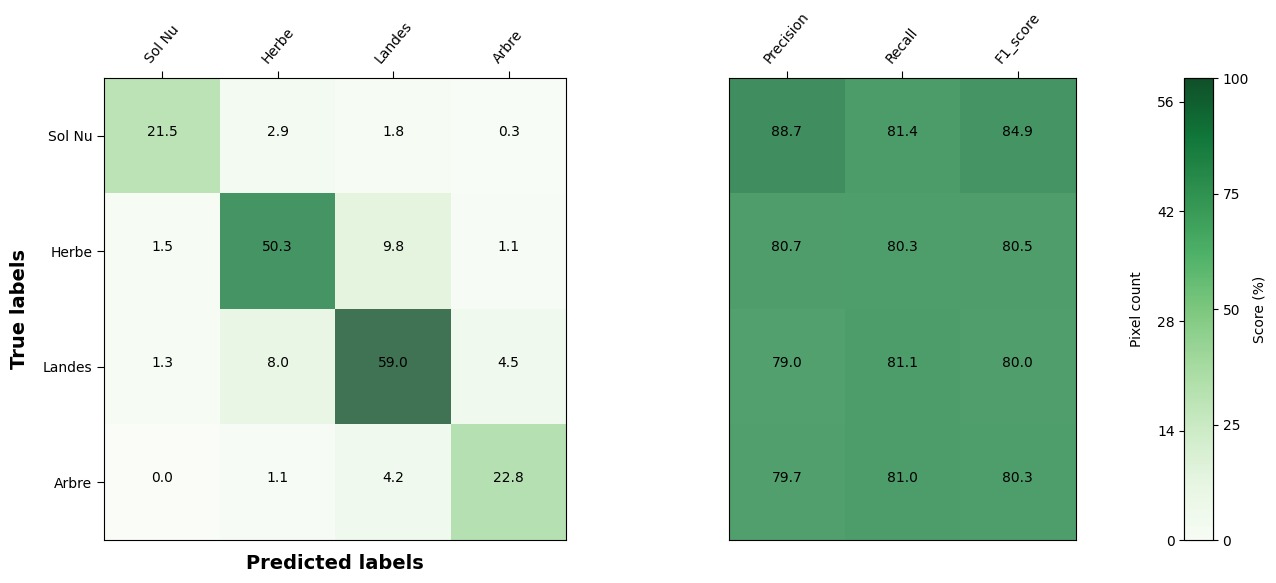

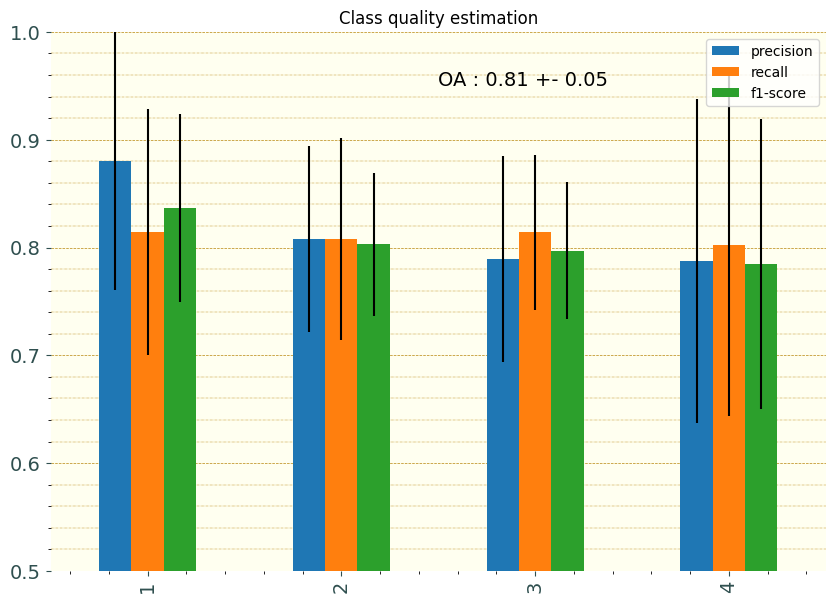

In [6]:
my.afficher_bilan_performances(stats)

### **Matrice de confusion**

**Classe Sol Nu** : Les prédictions correctes s'élèvent à 21,6 pixels. Les reports vers d'autres classes se répartissent entre l'Herbe (2,9), les Landes (1,9) et de manière marginale les Arbres (0,3).

**Interactions Herbe / Landes** : Ces deux classes présentent les volumes de pixels les plus importants. On enregistre un flux croisé de 10,4 pixels d'Herbe classés en Landes et de 8,9 pixels de Landes classés en Herbe.

**Classe Landes** : Outre la confusion avec l'Herbe, cette classe enregistre un report de 4,7 pixels vers la catégorie Arbre. C'est la classe présentant le plus haut effectif de pixels correctement assignés (61,5).

**Classe Arbre** : Le modèle comptabilise 22,1 pixels correctement identifiés. Les erreurs de classement se dirigent vers les Landes (3,8 pixels) et l'Herbe (1,1 pixel). Aucune confusion n'est relevée entre les classes Arbre et Sol Nu.

**Synthèse de la distribution des erreurs** : 

Les écarts de prédiction se concentrent sur les interfaces entre les classes de végétation (Herbe, Landes et Arbre). Les confusions entre les classes aux caractéristiques spectrales les plus opposées, notamment entre le Sol nu et les Arbres, sont statistiquement les plus faibles.

### **Performances de la classification** :

L'analyse des performances de la classification, évaluée par validation croisée sur 30 itérations, indique une précision globale (OA) de $0,81 \pm 0,04$. L’examen des métriques par catégorie révèle une hétérogénéité dans la discrimination des couverts : la classe Sol Nu présente les scores les plus élevés avec un F1-score de $0,88$, tandis que les classes Herbe et Landes affichent des performances identiques ($0,80$). La classe Arbre enregistre les valeurs les plus basses (F1-score de $0,77$). La matrice de confusion moyenne met en évidence que les erreurs de prédiction ne sont pas uniformément réparties. Si le Sol Nu est correctement identifié dans $21,6$ cas, les confusions majeures s'opèrent entre les classes Herbe et Landes, avec un flux croisé total de $19,3$ pixels. Enfin, la classe Arbre présente des reports systématiques vers les strates de végétation basse (Landes pour $3,8$ pixels et Herbe pour $1,1$ pixel), sans aucune confusion enregistrée avec la classe Sol Nu.



---
### **6. Importance des paramètres**

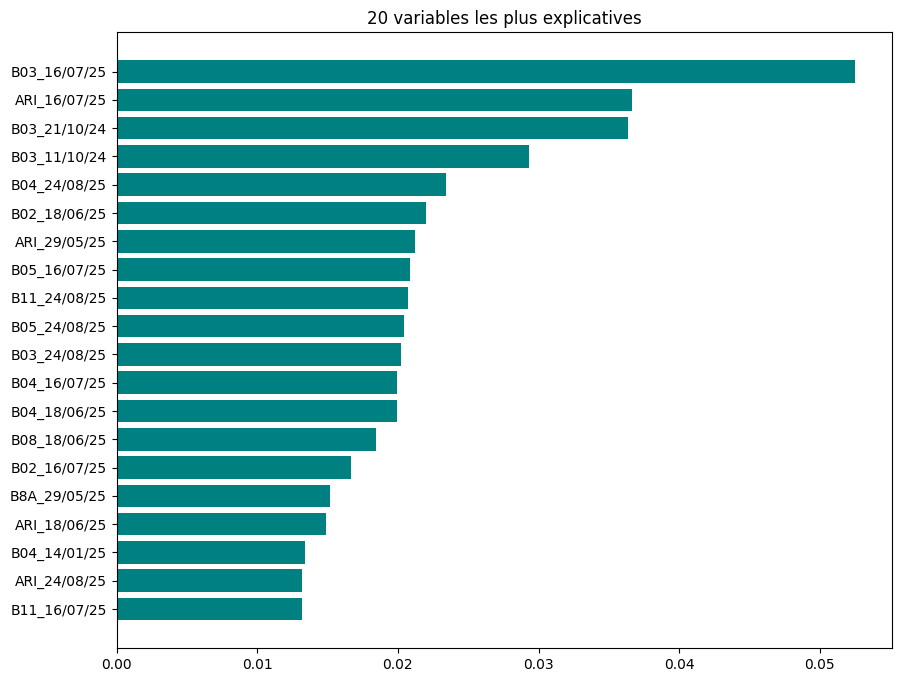

In [7]:
noms_feats = [f"{b}_{d}" for b in ["B02","B03","B04","B05","B06","B07","B08","B8A","B11","B12"] for d in dates] + [f"ARI_{d}" for d in dates]
my.afficher_importance(modele_final, noms_feats)

L’analyse de l’importance des variables, illustrée par le classement des vingt variables les plus contributives au modèle, met en évidence une prédominance des bandes spectrales et indices acquis en période estivale et de fin de printemps. La variable la plus influente correspond à la bande B03 acquise le 16/07/25, suivie par l’indice ARI de la même date et par la bande B03 du 21/10/24, soulignant le rôle majeur des informations liées au vert et aux pigments chlorophylliens dans la discrimination des classes.  La présence de variables issues de dates différentes, couvrant le printemps, l’été et le début de l’automne, indique que la dimension temporelle contribue significativement aux performances du modèle, en capturant les variations phénologiques des couverts.

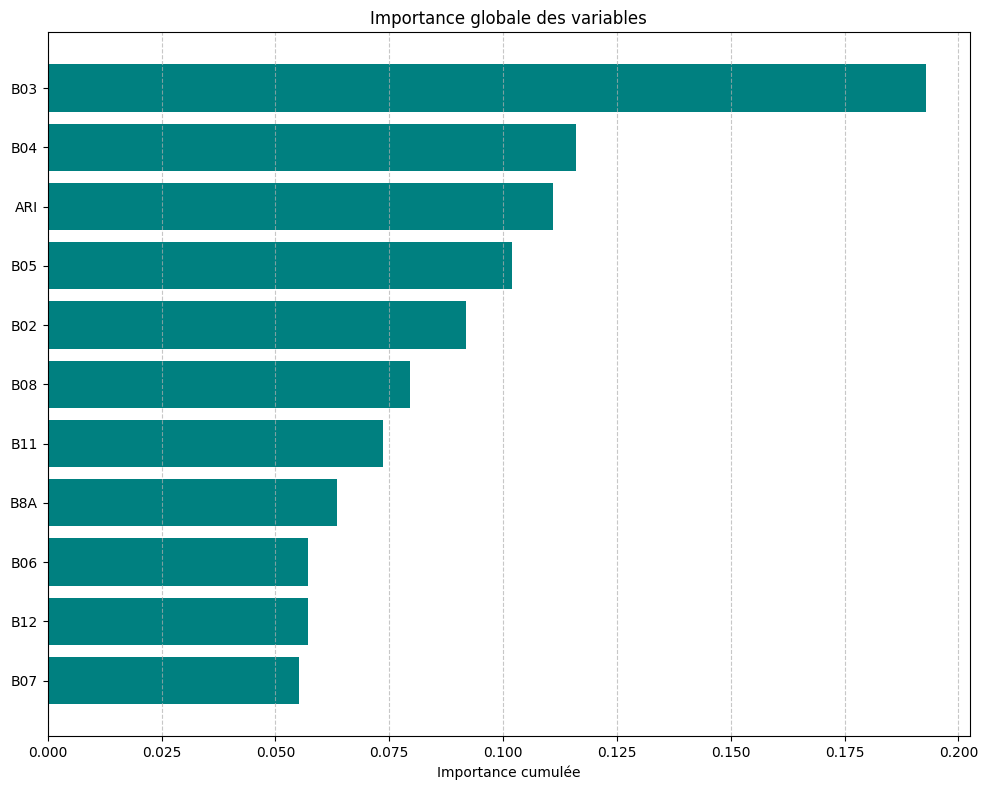

In [8]:
# Global
my.afficher_importance_globale(modele_final, noms_feats)

L’analyse de l’importance globale des variables, toutes dates confondues, confirme et généralise les tendances observées dans le classement des variables individuelles par date. La bande B03 apparaît comme la variable la plus contributive à l’échelle globale, avec une importance cumulée nettement supérieure aux autres, ce qui corrobore sa présence dominante parmi les variables les plus importantes identifiées précédemment à des dates estivales et automnales. Les bandes B04 et B05 ainsi que l’indice ARI occupent également des positions élevées, soulignant de manière cohérente le rôle central du visible et des indices liés aux pigments chlorophylliens dans la discrimination des classes de couvert. Les bandes B02 et B08, associées respectivement au bleu et au proche infrarouge, montrent l’apport complémentaire des informations sur la réflectance et la structure de la végétation. Par ailleurs, la contribution non négligeable des bandes du moyen infrarouge (B11 et B12) et des bandes red-edge (B8A, B06, B07) indique que les propriétés liées à l’humidité, à la biomasse et à la structure interne du couvert végétal renforcent la capacité discriminante du modèle. Ainsi, la cohérence entre l’importance globale des variables et leur récurrence parmi les variables dominantes à différentes dates souligne l’intérêt de combiner information spectrale et dynamique temporelle pour améliorer la robustesse et la stabilité des performances du modèle.

---
### **7. Création de la carte finale**

On passe du modèle statistique au résultat géographique.

**Prédiction spatiale** : Le modèle est appliqué à chaque pixel de l'image d'origine pour générer la carte de végétation finale.

Visualisation : Le dernier bloc affiche la carte avec une palette de couleurs normalisée, offrant une vision spatiale de la répartition des strates sur le massif des Pyrénées.

In [9]:
my.generer_carte_finale(modele_final, liste_fichiers_bandes, ari_path, '../results/carte_strates.tif')

Carte sauvegardée : ../results/carte_strates.tif


---
### **8. Evaluation visuelle de la classification**

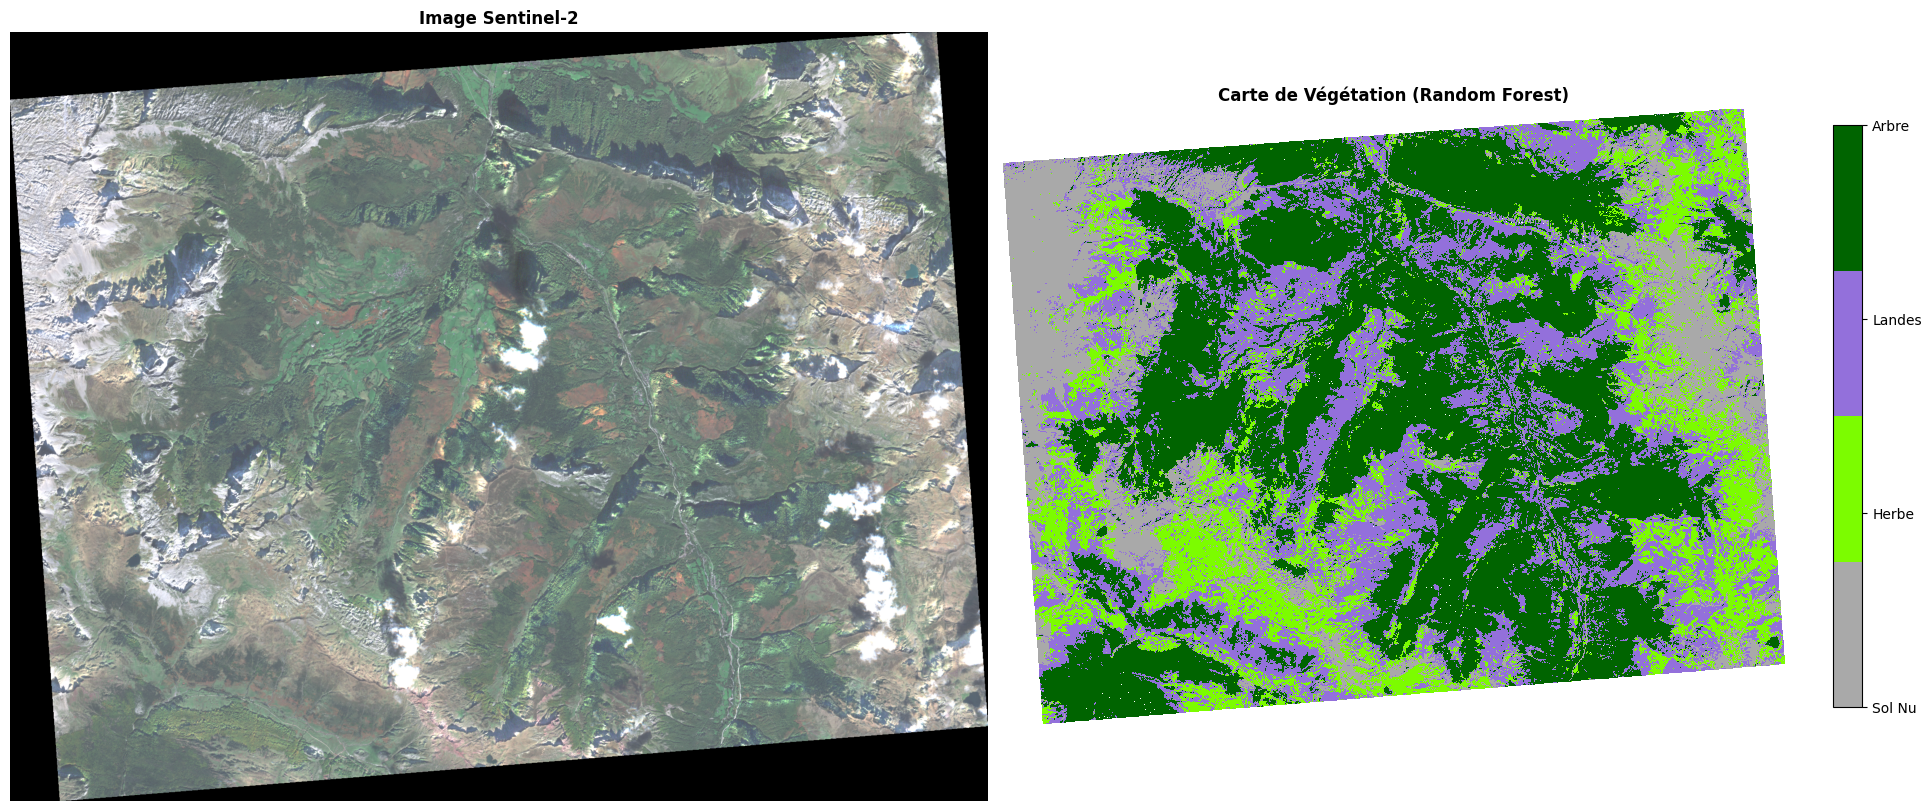

In [10]:
# Appel de la fonction
my.afficher_comparaison_finale([b04_path, b03_path, b02_path], '../results/carte_strates.tif')

1. Analyse de la qualité globale (Statistiques)

/img/Comparaison.png

2. Analyse de la qualité par classe